# Unaligning + Aligning Semi-Synthetic Images

This notebook demonstrates how we replicate the preprocessing step of image alignment for real SDSS images in our simulated images, which are generated in an aligned manner. SDSS images, for a given RCF, are unaligned across each version associated with a different band-pass filter. SDSS supports five bands - u, g, r, i and z. Each of these bands is also associated with its own WCS (World Coordinate System) object found within the HDU storing that band-pass filter's image. This band-specific WCS is critical for alignment, as we can project each of the images onto an arbitrarily chosen reference WCS for the same RCF that results in five images which are all aligned pixel-wise. 

## Setup

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
from os import environ
import torch
from pathlib import Path
from hydra import initialize, compose
from hydra.utils import instantiate
import matplotlib.pyplot as plt

from bliss.surveys.sdss import SloanDigitalSkySurvey
from bliss.simulator import simulated_dataset

In [3]:
environ["BLISS_HOME"] = str(Path().resolve().parents[1])
with initialize(config_path=".", version_base=None):
    cfg = compose("config")

## Real SDSS Images

Here, we will show the unaligned nature of real SDSS images which has to be corrected during prediction time.

In [4]:
# retrieve SDSS object containing UGRIZ image for (94, 1, 12)
sdss = instantiate(cfg.surveys.sdss)

<Figure size 640x480 with 0 Axes>

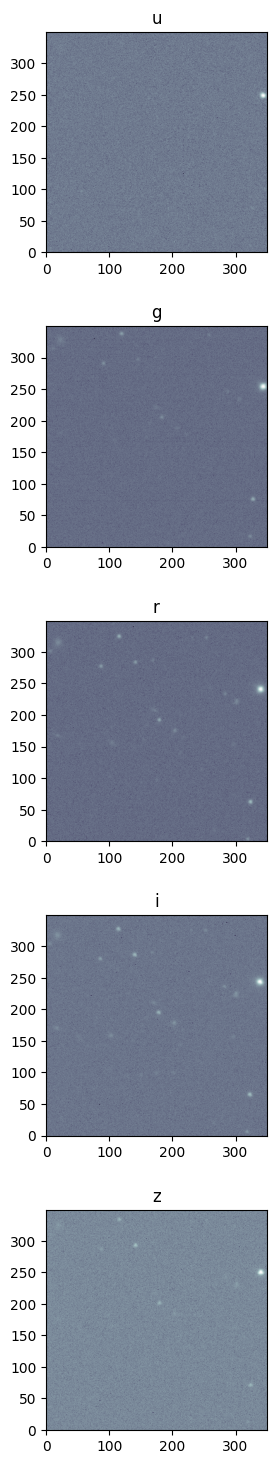

In [5]:
# Here, create plot of SDSS images and their reprojections
plt.figure().clear()

d = {}
wcs_per = {}
for i, bnd in enumerate('ugriz'):
    d[bnd] = sdss[0]['image'][i]
    wcs_per[f'{bnd}'] = sdss[0]['wcs'][i]

fig, axs = plt.subplots(5, 1, figsize=(35, 15))
for i, key in enumerate(d.keys()):
    img = d[key]
    img = img[:350, :350]
    axs[i].imshow(np.log(np.clip(img - (np.min(img)), a_min=1, a_max=None)), cmap='bone', origin='lower')
    axs[i].set_title(f'{key}')

fig.tight_layout(pad=2.0)
plt.show()

Though it is difficult to notice due to the size of these SDSS images (1489x2048), each light source in the above images could possibly be slightly offset relative to its position in an other band-pass filter. This is likely due to the position of the filters in the telescope in addition to any possible atmospheric disturbances that affect certain wavelengths of light more than others. For example, the light source on the right side of each image at about y=250 appears to deviate further and further from the right border as you look from the top down.

We can show that this is the case by observing that:

In [6]:
(sdss[0]["image"][2, :350, :350] == sdss[0]["image"][2, :350, :350].max()).nonzero()

(array([240]), array([340]))

In [7]:
(sdss[0]["image"][0, :350, :350] == sdss[0]["image"][0, :350, :350].max()).nonzero()

(array([247]), array([343]))

Here, the maximum pixel value in the r-band image is found at (240, 340) whereas the maximum pixel value in the u-band image is found at (247, 343). Both correspond to the same light source (can confirm visually), but are found in two different locations in pixel-space.

To correct for this, we must reproject each image according to the WCS object of a reference image that adjusts for the displacement in pixel space and performs an interpolation for a smooth output. We can utilize the **reproject_interp** function from the **reproject** library to do this. BLISS has its own **align** function that can be used for this purpose, relying on the aforementioned function for pixel alignment across multi-band images.

In [8]:
from bliss.predict import align

## Simulating Images

We generate semi-synthetic data from a catalog that is created over a distribution over all survey-specific catalog parameters. Adjusting the prior within our image decoder, we can create images strikingly similar to each survey whose catalog it models. However, these images are already perfectly aligned - unlike the real data. We know that interpolation inherently smooths noise over the image it operates on, and our simulated images have added Poisson-distributed noise that does not get smoothed fresh out of generation. Additionally, we would like to replicate the real survey images as closely as possible - even the quality of having unaligned per-band images. So how can we replicate this?

We can instantiate a collection of curated WCS objects for each of the per-band images, configure them so that they each have a random offset added to their center in pixel space relative to one of the images, and utilize those objects to both unalign and subsequently realign them!

### Generating simulated images

First, we'll instantiate our BLISS simulator.

In [9]:
simulator = instantiate(cfg.simulator)

/home/sawanpa/bliss/.venv/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Next, we'll sample a tile catalog over our prior distribution, which mocks SDSS.

In [10]:
tc = simulator.catalog_prior.sample()

We call the **randomized_image_ids** class method to return a list of RCFs that are used to gather information specific to the image background and other features. This is out of scope for this demo but we require the **image_ids** value as an argument to the **render_images** decoder class method.

In [11]:
image_ids, image_id_indices = simulator.randomized_image_ids(simulator.catalog_prior.batch_size)

Now, we pass the sampled tile catalog and the image_ids to the decoder object's **render_images** function to retrieve our unaligned images, psfs, psf parameters and a list of custom WCS objects tuned to the random perturbation done to each per-band image which can be used to re-align our simulated images. 

Note again that the images returned by this function are unaligned - this is a result of adding a two-dimensional perturbation generated from a parameterized Uniform distribution which is outlined in the config file. 

In [12]:
images, psfs, psf_params, wcs_undo = simulator.image_decoder.render_images(tc, image_ids)

In [14]:
fc = tc.to_full_params()

We can plot the first semi-synthetic image below to verify that the images don't perfectly overlap with each other, as is observed in real SDSS data. 

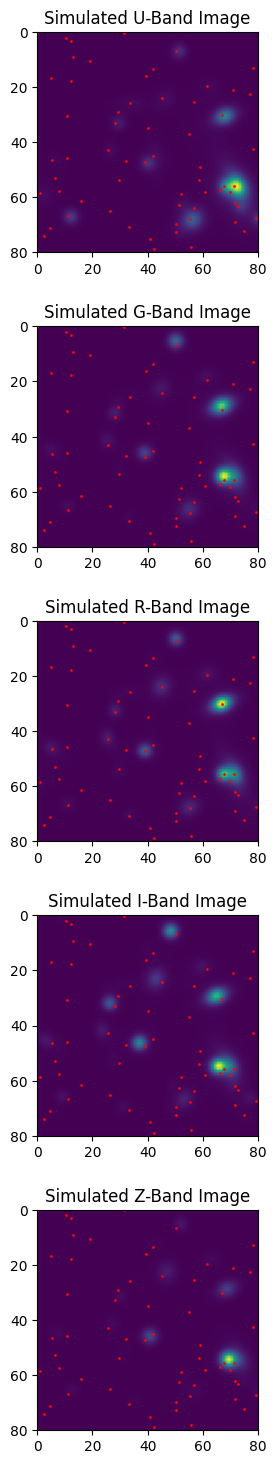

In [32]:
d = {0: 'U', 1: 'G', 2: 'R', 3: 'I', 4: 'Z'}
fig, axs = plt.subplots(5, 1, figsize=(35, 15))
for i in range(images.shape[1]):
    axs[i].imshow(images[0, i], extent=[0, 80, 80, 0])
    axs[i].scatter(fc['plocs'][0, :, 1], fc['plocs'][0, :, 0], s=1, c='r')
    axs[i].set_title(f"Simulated {d[i]}-Band Image")

fig.tight_layout(pad=2.0)
plt.show()

Note that the pixel shift in each direction is sampled from X ~ Unif(0, 2). Therefore, the maximum number of shift in any one direction is 2 - which is not very noticeable to the naked eye. The source in the top-right shown in the Z-band is a good one to track to notice the pixel shifting. The R-band image is aligned, as we generally see in the real SDSS data.

### Realigning simulated images

Now that we have a collection of unaligned, SDSS-like images, we can process them in a similar manner by reprojecting them according to a reference band WCS so they are aligned according to that particular band.

First, we create a deep copy of our generated, unaligned images.

In [33]:
import copy

img_copy = copy.deepcopy(images)

Now, we use the **align** function to reproject each image with it's corresponding WCS object according to a reference band, which in our case is the r-band. 

In [34]:
from bliss.predict import align

for i in range(img_copy.shape[0]):
    img_copy[i] = torch.from_numpy(
        align(
            img_copy[i].numpy(),
            wcs_undo[i],
            simulator.catalog_prior.b_band,
        )
    )

We can plot our results below, showing that each of the simulated images is now aligned as they were prior to the random perturbations being added!

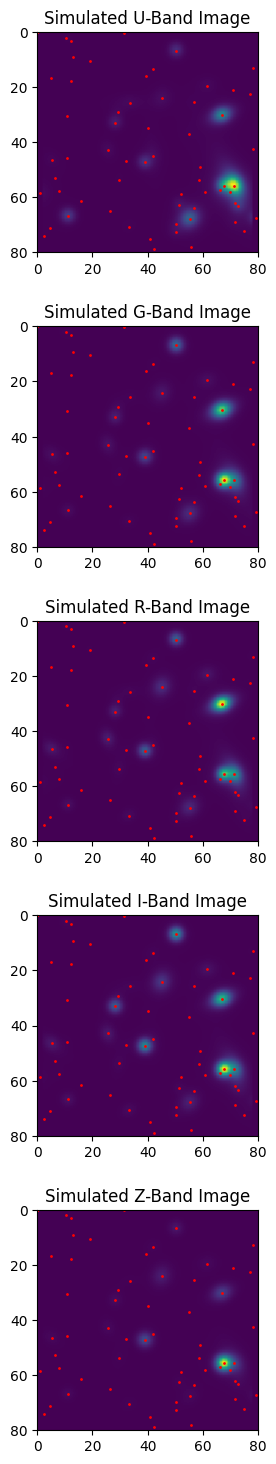

In [37]:
fig, axs = plt.subplots(5, 1, figsize=(35, 15))
for i in range(img_copy.shape[1]):
    axs[i].imshow(img_copy[0, i], extent=[0, 80, 80, 0])
    axs[i].scatter(fc['plocs'][0, :, 1], fc['plocs'][0, :, 0], s=1, c='r')
    axs[i].set_title(f'Simulated {d[i]}-Band Image')

fig.tight_layout(pad=2.0)
plt.show()

## End-to-End

Rather than run all of the above, this workflow is built into the BLISS Simulator!

In [81]:
# End-to-End decoding
tc = simulator.catalog_prior.sample()
image_ids, image_id_indices = simulator.randomized_image_ids(simulator.catalog_prior.batch_size)
imgs, bgs, deconv_params, psf_params = simulator.simulate_image(tc, image_ids, image_id_indices)